In [950]:
import pyspark
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import math
import datetime
from datetime import timedelta
import seaborn as sns
import warnings

spark = SparkSession.builder.appName("bigdata")\
                    .config("spark.some.config.option", "some-value")\
                    .getOrCreate()

In [951]:
%run data.py
warnings.filterwarnings("ignore")  # ignore warnings

In [952]:
# filter the dataframe, just leave the cases, deaths and ever-hospitalized
nycBorough = fetchData(nyc_his_boro_url)
borough = nycBorough[(nycBorough.type == "cases") | (nycBorough.type == "deaths") | (nycBorough.type == "ever-hospitalized")]

# change the timestamp to date and rearrange the columns
borough[["date","time"]] = borough["timestamp"].str.split("T", expand = True)
borough = borough[["date","type","bronx","brooklyn","manhattan","queens","staten_island","unknown","total"]]
borough["date"] = pd.to_datetime(borough['date'])
#borough.head(5)

# get the latest data for condirmed cases, deaths and hospitalized
update = borough.tail(3)
update.set_index(["type"], inplace = True) 
update

,date,bronx,brooklyn,manhattan,queens,staten_island,unknown,total
type,,,,,,,,
cases,2020-05-06,39878,46579,21662,54121,12380,89,174709
deaths,2020-05-06,3082,4260,1874,4269,669,8,14162
ever-hospitalized,2020-05-06,10186,11660,5919,14011,1948,20,43744


In [953]:
# function for getting start/end date and time range of dataframe
def getStartDate(inputeData):
    firstRow = inputeData.head(1)
    start_date = firstRow.iloc[[0],[0]].values[0][0]
    start_date = pd.to_datetime(str(start_date)).strftime("%Y-%m-%d")
    return start_date

def getLastDate(inputeData):
    lastRow = inputeData.tail(1)
    latest_date = lastRow.iloc[[0],[0]].values[0][0]
    latest_date = pd.to_datetime(str(latest_date)).strftime("%Y-%m-%d")
    return latest_date

def getTimeRange(inputeData):
    print("Update: " + getLastDate(inputeData) + "\t(from " + getStartDate(inputeData) + ")")

In [954]:
# regional all data generalize function
def regionData (regionSourceData, region):
    case = regionSourceData[(regionSourceData.type == "cases")]
    death = regionSourceData[(regionSourceData.type == "deaths")]
    hosp = regionSourceData[(regionSourceData.type == "ever-hospitalized")]
    
    case.rename(columns = {region:"cases"}, inplace = True)
    case.drop_duplicates(subset = "date", keep = "last", inplace = True)
    case.drop(columns = ["type"], inplace = True)
    
    death.rename(columns = {region:"deaths"}, inplace= True)
    death.drop_duplicates(subset = "date", keep = "last", inplace = True)
    death.drop(columns = ["type"], inplace = True)

    hosp.rename(columns = {region:"ever-hospitalized"}, inplace = True)
    hosp.drop_duplicates(subset = "date", keep = "last", inplace = True)
    hosp.drop(columns = ["type"], inplace = True)
    
    mergeHelper = pd.merge(case, hosp, how = "outer", on = ["date"])
    regionAllData = pd.merge(mergeHelper, death, how = "outer", on = ["date"])
    regionAllData = regionAllData.fillna(0)
    regionAllData[["cases", "ever-hospitalized", "deaths"]] \
                    = regionAllData[["cases", "ever-hospitalized", "deaths"]].astype(int)
    return regionAllData

In [955]:
# regional plot generalize function
def regionPlot (regionAllData, region):
    df = regionAllData
    #df["date"] = df["date"].astype(np.str_)
    #df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")

    df[["cases","ever-hospitalized","deaths"]].plot.area(stacked = False, cmap = "tab10_r")
    plt.title(region.capitalize() + " COVID-19 Data", fontsize = 20)
    plt.legend()
    plt.show()

# NYC COVID-19 Summary

In [956]:
# Summary data updated date 
getTimeRange(borough)

Update: 2020-05-06	(from 2020-03-12)


In [957]:
# NYC summary 
# rearrange col and row
nycSummary = update.drop(columns = ["date"])
cm = sns.light_palette("#66cccc", as_cmap = True)
df1 = nycSummary.stack()
df2 = df1.unstack(0)
df2.style.background_gradient(cmap = cm)

type,cases,deaths,ever-hospitalized
bronx,39878,3082,10186
brooklyn,46579,4260,11660
manhattan,21662,1874,5919
queens,54121,4269,14011
staten_island,12380,669,1948
unknown,89,8,20
total,174709,14162,43744


# NYC COVID-19 Summary by Date

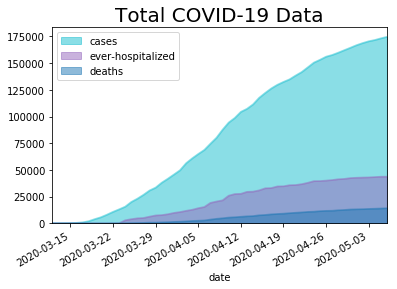

In [958]:
# case, death, haspitalized data for NYC 
nycSourceData = borough[["date","type","total"]] 
region = "total"
nycAllData = regionData (nycSourceData, region)
regionPlot (nycAllData, region)

# Information for Each Borough

In [959]:
# Cases / Deaths / Hosplitalized Data for Each Borough

# Bronx Data

In [960]:
# case, death, haspitalized data for bronx 
bronxData = borough[["date","type","bronx"]] 
region = "bronx"
bronxAllData = regionData (bronxData, region)
bronxAllData.tail(5)

,date,cases,ever-hospitalized,deaths
50,2020-05-02,38599,9941,2886
51,2020-05-03,38973,10007,2936
52,2020-05-04,39239,10084,2997
53,2020-05-05,39587,10147,3046
54,2020-05-06,39878,10186,3082


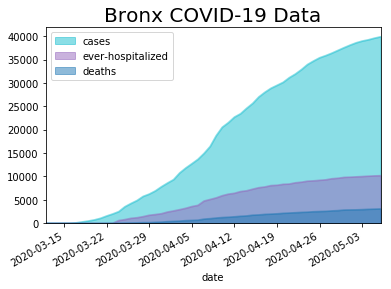

In [961]:
regionPlot (bronxAllData, region)

# Brooklyn Data

In [962]:
# case, death, haspitalized data for brooklyn
brooklynData = borough[["date","type","brooklyn"]] 
region = "brooklyn"
brooklynAllData = regionData (brooklynData, region)
brooklynAllData.tail(5)

,date,cases,ever-hospitalized,deaths
50,2020-05-02,44867,11437,4014
51,2020-05-03,45341,11469,4080
52,2020-05-04,45637,11565,4127
53,2020-05-05,46139,11641,4194
54,2020-05-06,46579,11660,4260


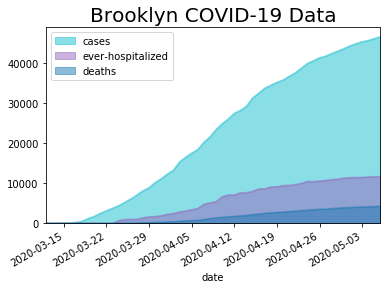

In [963]:
regionPlot (brooklynAllData, region)

# Manhattan Data

In [964]:
# case, death, haspitalized data for manhattan
manhattanData = borough[["date","type","manhattan"]]
region = "manhattan"
manhattanAllData = regionData (manhattanData, region)
manhattanAllData.tail(5)

,date,cases,ever-hospitalized,deaths
50,2020-05-02,20892,5825,1752
51,2020-05-03,21125,5836,1774
52,2020-05-04,21287,5869,1797
53,2020-05-05,21470,5917,1822
54,2020-05-06,21662,5919,1874


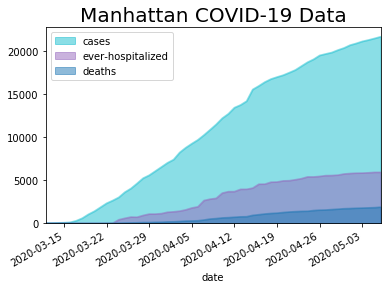

In [965]:
regionPlot (manhattanAllData, region)

# Queens Data

In [966]:
# case, death, haspitalized data for queens
queensData = borough[["date","type","queens"]] 
region = "queens"
queensAllData = regionData (queensData, region)
queensAllData.tail(5)

,date,cases,ever-hospitalized,deaths
50,2020-05-02,52305,13782,4035
51,2020-05-03,52845,13805,4102
52,2020-05-04,53243,13915,4149
53,2020-05-05,53692,14003,4213
54,2020-05-06,54121,14011,4269


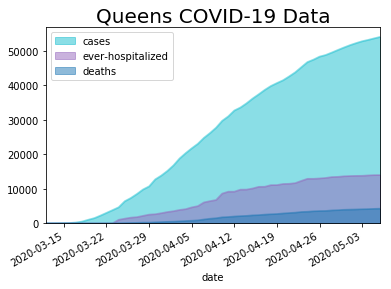

In [967]:
regionPlot (queensAllData, region)

# Staten Island Data

In [968]:
# case, death, haspitalized data for staten_island
staten_islandData = borough[["date","type","staten_island"]] 
region = "staten_island"
staten_islandAllData = regionData (staten_islandData, region)
staten_islandAllData.tail(5)

,date,cases,ever-hospitalized,deaths
50,2020-05-02,12101,1905,624
51,2020-05-03,12169,1909,636
52,2020-05-04,12235,1931,646
53,2020-05-05,12311,1948,655
54,2020-05-06,12380,1948,669


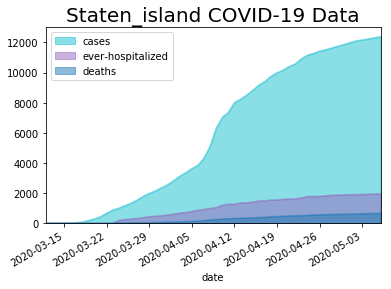

In [969]:
regionPlot (staten_islandAllData, region)

# NYC Cases and Tasted Data

In [970]:
# filter the dataframe, just leave the date and number of tasted
nycTestSource = fetchData(nyc_his_state_url)
nycTest = nycTestSource[["timestamp","nyc_tested","nyc_cases"]]
nycTest = nycTest.fillna(0)
nycTest[["nyc_tested","nyc_cases"]] = nycTest[["nyc_tested","nyc_cases"]].astype(int)

nycTest[["date","time"]] = nycTest["timestamp"].str.split("T", expand = True)
nycTest = nycTest[["date","nyc_tested","nyc_cases"]]
nycTest["date"] = pd.to_datetime(nycTest["date"])

# NYC test data update date
getTimeRange(nycTest)

Update: 2020-05-07	(from 2020-03-16)


In [971]:
nycTest.tail(5)

,date,nyc_tested,nyc_cases
48,2020-05-03,465803,174331
49,2020-05-04,474986,175651
50,2020-05-05,485803,176874
51,2020-05-06,498849,178351
52,2020-05-07,515218,180216


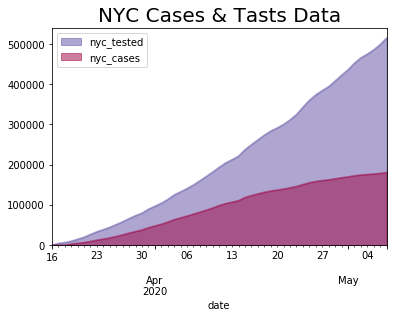

In [972]:
nycTest = nycTest.set_index("date")
nycTest.plot.area(stacked = False, cmap = "Spectral_r")
plt.title("NYC Cases & Tasts Data", fontsize = 20)
plt.legend()
plt.show()

# Cases by Age Group

In [973]:
# cases by age
casesAge = fetchData(nyc_his_age_url)

# filter the dataframe, just leave the date and number of tasted
ageGroup = casesAge[["timestamp","type","ages_0_17","ages_18_44","ages_45_64","ages_65_74","ages_75_older","unknown"]]
ageGroup[["date","time"]] = ageGroup["timestamp"].str.split("T", expand = True)
ageGroup = ageGroup[["date","type","ages_0_17","ages_18_44","ages_45_64","ages_65_74","ages_75_older","unknown"]]
ageGroup["date"] = pd.to_datetime(ageGroup["date"])

# summary of age group
ageGroupCase = ageGroup[(ageGroup.type == "cases")]
ageGroupCase.drop_duplicates(subset = "date", keep = "last", inplace = True)
ageGroupCaseUpdate = ageGroupCase.tail(1)

ageGroupDeath = ageGroup[(ageGroup.type == "deaths")]
ageGroupDeath.drop_duplicates(subset = "date", keep = "last", inplace = True)
ageGroupDeathUpdate = ageGroupDeath.tail(1)

frames = [ageGroupCaseUpdate, ageGroupDeathUpdate]
ageGroupUpdate = pd.concat(frames).drop(columns=["date"])
ageGroupUpdate.set_index(["type"], inplace = True) 

In [974]:
getTimeRange(ageGroup)

Update: 2020-05-06	(from 2020-03-22)


In [975]:
# cases and deaths for age group
# rearrange col and row
cm = sns.light_palette("#ff7000", as_cmap = True)
df1 = ageGroupUpdate.stack()
df2 = df1.unstack(0)
df2.style.background_gradient(cmap = cm)

type,cases,deaths
ages_0_17,4246,6
ages_18_44,64244,566
ages_45_64,64143,3170
ages_65_74,21770,3511
ages_75_older,19971,6907
unknown,335,2


# NYC COVID-19 Cases Prediction

In [976]:
test = nycAllData[["date","cases"]]
firstDay = getStartDate(test)
lastDay = getLastDate(test)
start = datetime.datetime.strptime(firstDay, "%Y-%m-%d")
end = datetime.datetime.strptime(lastDay, "%Y-%m-%d")

days = len(test)
Time = np.arange(1,days+1)
P = np.array(test["cases"])

In [977]:
# t:time t0:initial time P0:initial value K:capacity r:increase rate
# greater r faster to K

fast_r = 0.09
slow_r = 0.11

def logisticIncreaseFunction(t,K,P0,r):
    t0 = 1
    exp_value = np.exp(r*(t-t0))
    return (K*exp_value*P0)/(K+(exp_value - 1)*P0)

def fasterLIF(t,K,P0):
    return logisticIncreaseFunction(t,K,P0,r = fast_r)

def slowerLIF(t,K,P0):
    return logisticIncreaseFunction(t,K,P0,r = slow_r)

In [978]:
def nearFuture(startDate, num):
    delta = datetime.timedelta(days = 1)
    predict = pd.DataFrame(columns = ["date", "fast growth", "slow growth"])
    for i in range(1, num+1):
        curr = startDate + delta * (days+i) 
        currDate = curr.strftime("%Y-%m-%d")
        fast = int(fasterLIF(np.array(days+i),poptFast[0],poptFast[1]))
        slow = int(slowerLIF(np.array(days+i),poptSlow[0],poptSlow[1]))
        
        predict = predict.append(pd.DataFrame({"date":[currDate], "fast growth":[fast], "slow growth":[slow]}),ignore_index = True) 
        
    return predict

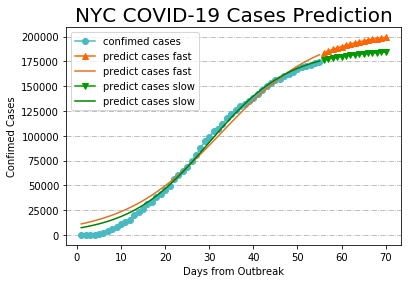

In [983]:
# data fitting: least squares approximation 
# popt: coefficient pcov：covariance matrix
poptFast, pcovFast = curve_fit(fasterLIF, Time, P)
poptSlow, pcovSlow = curve_fit(slowerLIF, Time, P)

# predict cases
predictCasefast = fasterLIF(Time,poptFast[0],poptFast[1])
predictCaseSlow = slowerLIF(Time,poptSlow[0],poptSlow[1])

# near future predict cases
nextDay = np.arange(days+1, days+16)
nextDay_predictFast = logisticIncreaseFunction(nextDay,poptFast[0],poptFast[1],r = fast_r)
nextDay_predictSlow = logisticIncreaseFunction(nextDay,poptSlow[0],poptSlow[1],r = slow_r)

plot1 = plt.plot(Time, P, color = "#49b9c2", marker = "o", label = "confimed cases")
plot2 = plt.plot(nextDay, nextDay_predictFast, color = "#ff6500", marker = "^", label = "predict cases fast")
plot3 = plt.plot(Time, predictCasefast, color = "#e17223",label = "predict cases fast")
plot4 = plt.plot(nextDay, nextDay_predictSlow, color = "#009900", marker = "v", label = "predict cases slow")
plot5 = plt.plot(Time, predictCaseSlow, color = "#008000",label = "predict cases slow")

plt.xlabel("Days from Outbreak")
plt.ylabel("Confimed Cases")
plt.title("NYC COVID-19 Cases Prediction", fontsize = 20)
plt.grid(axis = "y",linestyle = "-.") 
plt.legend()
plt.show()

# NYC COVID-19 Cases Prediction in A Week

In [984]:
nearFuture(start, 7)

,date,fast growth,slow growth
0,2020-05-07,183620,176423
1,2020-05-08,185376,177423
2,2020-05-09,187011,178328
3,2020-05-10,188531,179147
4,2020-05-11,189941,179887
5,2020-05-12,191249,180556
6,2020-05-13,192460,181158


In [981]:
# end